Generating motorica videos for labeling

In [1]:
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# print out current working directory
print(Path.cwd())

c:\Users\siyuan\research\smpl2motorica


In [3]:
dataset_path = Path("./data/motorica_dance_dataset")
if not dataset_path.exists():
    raise FileNotFoundError(f"Dataset path {dataset_path} not found")
mocap_path = dataset_path / "bvh"
music_path = dataset_path / "wav"

In [4]:
# get a list of bvh files that has corresponding music files
bvh_files = list(mocap_path.glob("*.bvh"))
print(f"total bvh files: {len(bvh_files)}")
music_files = list(music_path.glob("*.wav"))
bvh_files = [bvh for bvh in bvh_files if any(bvh.stem in music.stem for music in music_files)]
print(f"Found {len(bvh_files)} bvh files with corresponding music files")



total bvh files: 121
Found 97 bvh files with corresponding music files


In [5]:
import sys
sys.path.append("../")
from smpl2motorica.utils.bvh import BVHParser
from smpl2motorica.utils.pymo.preprocessing import MocapParameterizer

In [6]:
def motorica_draw_stickfigure3d(
    fig,
    mocap_track,
    frame,
    data=None,
    joints=None,
    draw_names=True,
):
    from mpl_toolkits.mplot3d import Axes3D

    ax = fig.add_subplot(111, projection="3d")
    # ax.view_init(elev=0, azim=120)

    if joints is None:
        joints_to_draw = mocap_track.skeleton.keys()
    else:
        joints_to_draw = joints

    if data is None:
        df = mocap_track.values
    else:
        df = data

    for idx, joint in enumerate(joints_to_draw):
        # ^ In mocaps, Y is the up-right axis
        parent_x = df["%s_Xposition" % joint][frame]
        parent_y = df["%s_Zposition" % joint][frame]
        parent_z = df["%s_Yposition" % joint][frame]

        # parent_x = df["%s_Xposition" % joint][frame]
        # parent_y = df["%s_Yposition" % joint][frame]
        # parent_z = df["%s_Zposition" % joint][frame]

        ax.scatter(xs=parent_x, ys=parent_y, zs=parent_z, alpha=0.6, c="b", marker="o")
        

        children_to_draw = [
            c for c in mocap_track.skeleton[joint]["children"] if c in joints_to_draw
        ]

        for c in children_to_draw:
            # ^ In mocaps, Y is the up-right axis
            child_x = df["%s_Xposition" % c][frame]
            child_y = df["%s_Zposition" % c][frame]
            child_z = df["%s_Yposition" % c][frame]

            # child_x = df["%s_Xposition" % c][frame]
            # child_y = df["%s_Yposition" % c][frame]
            # child_z = df["%s_Zposition" % c][frame]



            ax.plot(
                [parent_x, child_x],
                [parent_y, child_y],
                [parent_z, child_z],
                # "k-",
                lw=2,
                c="black",
            )

        if draw_names:
            ax.text(
                x=parent_x - 0.01,
                y=parent_y - 0.01,
                z=parent_z -0.01,
                s=f"{idx}:{joint}",
                fontsize=5,
            )

    return ax

In [7]:
dataset_fps = 120
target_fps = 10
# load one bvh file
bvh_file = bvh_files[0]
bvh_parser = BVHParser()
mocap_track = bvh_parser.parse(bvh_file)
# Sample the mocap track
length = len(mocap_track.values)
print(f"Total frames: {length}")
sampled_indices = np.arange(0, length, int(dataset_fps / target_fps))
mocap_track.values = mocap_track.values.iloc[sampled_indices]
mocap_track.values.reset_index(drop=True, inplace=True)
print(f"Sampled frames: {len(mocap_track.values)}")
position_mocap = MocapParameterizer("position").fit_transform([mocap_track])[0]

Total frames: 20560
Sampled frames: 100


In [8]:
# load music file
music_file = music_path / (bvh_file.stem + ".wav")
if not music_file.exists():
    raise FileNotFoundError(f"Music file {music_file} not found")


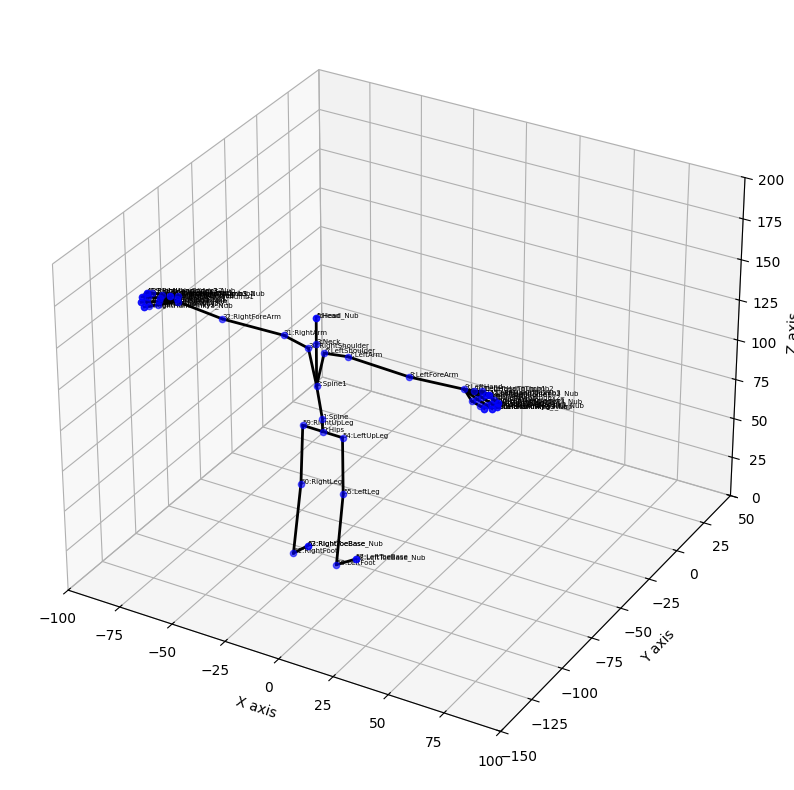

In [9]:
frame = 0
fig = plt.figure(figsize=(10, 10))
motorica_ax = motorica_draw_stickfigure3d(
            fig=fig,
            mocap_track=position_mocap, frame=frame, draw_names=True
        )
motorica_ax.set_xlabel('X axis')
motorica_ax.set_ylabel('Y axis')
motorica_ax.set_zlabel('Z axis')
motorica_ax.set_zlim([0, 200])
motorica_ax.set_xlim([-100, 100])
motorica_ax.set_ylim([-150, 50])
plt.show()

In [10]:
import cv2
import os
from tqdm import tqdm
from moviepy.editor import VideoFileClip, AudioFileClip

def save_video(data, music_file):
    df = data.values
    image_folder = 'tmp'
    os.makedirs(image_folder, exist_ok=True)
    
    for frame in tqdm(range(len(df)), desc="Generating Videos"):
        fig = plt.figure(figsize=(10, 10))
        motorica_ax = motorica_draw_stickfigure3d(
            fig=fig,
            mocap_track=data, frame=frame, draw_names=True
        )
        motorica_ax.set_xlabel('X axis')
        motorica_ax.set_ylabel('Y axis')
        motorica_ax.set_zlabel('Z axis')
        motorica_ax.set_zlim([0, 200])
        motorica_ax.set_xlim([-100, 100])
        motorica_ax.set_ylim([-150, 50])
        motorica_ax.set_title(f"frame {frame}")
        plt.savefig(f"{image_folder}/frame_{frame:04d}.png")
        plt.close(fig)
    
    # compile the video
    video_name = 'sample_motorica_vid.mp4'
    images = [img for img in os.listdir(image_folder) if img.endswith(".png")]
    frame = cv2.imread(os.path.join(image_folder, images[0]))
    height, width, layers = frame.shape

    fps = target_fps  # Set frames per second
    video = cv2.VideoWriter(video_name, cv2.VideoWriter_fourcc(*'mp4v'), fps, (width, height))

    for image in images:
        video.write(cv2.imread(os.path.join(image_folder, image)))

    cv2.destroyAllWindows()
    video.release()
    
    # Add music to the video
    video_clip = VideoFileClip(video_name)
    audio_clip = AudioFileClip(str(music_file))
    final_clip = video_clip.set_audio(audio_clip)
    final_clip.write_videofile("output_with_music.mp4", codec='libx264', audio_codec='aac')

    # remove the images and directory
    for image in images:
        os.remove(os.path.join(image_folder, image))
    os.rmdir(image_folder)
    
    return "output_with_music.mp4"

In [11]:
save_video(position_mocap, music_file)

Generating Videos: 100%|██████████| 100/100 [00:44<00:00,  2.22it/s]


Moviepy - Building video output_with_music.mp4.
MoviePy - Writing audio in output_with_musicTEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video output_with_music.mp4



Moviepy - Done !
Moviepy - video ready output_with_music.mp4


'output_with_music.mp4'